In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import uproot, wandb, os, logging, json, random
import awkward as ak
# import torch
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform, norm
from matplotlib.ticker import FormatStrFormatter

# ML model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Config
from bdt_config import sample_dict, zbi, getVarDict
from bdt_config import Vars, Vars2, Vars3, Vars_drop, Vars_plot
from bdt_config import variables, ntuple_name, ntuple_name_BDT

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

# Check for gpu
# torch.cuda.is_available()

df_ml_input = pd.read_csv("bdt_ml_input_correlation.csv")
df_ml_input

,metsig,met,met_noJVT,dmet,dphi_met_phterm,dphi_ph_centraljet1,dphi_phterm_jetterm,jetterm,dphi_met_central_jet,BDTScore,...,label,process,metsigres,ph_pt,ph_eta,dphi_met_jetterm,failJVT_jet_pt1,n_jet_central,dphi_jj,bdtscore2
0,2.761993,106920.875,106920.875,0.0,0.938348,2.772006,1.602420,84722.190,1.307934,0.131412,...,1,ggHyyd,0.000026,0.000015,1.116581,1.505859,0.000046,1.000000,NaN,0.000320
1,8.542773,102183.560,102183.560,0.0,1.180506,1.609753,1.609753,86744.400,2.712346,0.151073,...,1,ggHyyd,0.000084,0.000019,7.054524,2.329661,NaN,1.000000,NaN,0.070852
2,6.480173,113106.060,113106.060,0.0,1.881112,2.767581,2.523243,186978.030,2.255124,0.326790,...,1,ggHyyd,0.000057,0.000008,0.618951,1.557315,NaN,0.333333,3.187578,0.018054
3,5.958667,131013.914,131013.914,0.0,1.852292,2.392476,2.202219,176778.980,2.601409,0.267467,...,1,ggHyyd,0.000045,0.000015,0.500710,2.857742,0.000029,0.333333,0.461536,0.004883
4,2.547094,125378.336,125378.336,0.0,0.323595,1.838230,0.870069,49163.324,1.626958,0.189026,...,1,ggHyyd,0.000020,0.000011,0.438361,1.829915,NaN,0.500000,0.374474,0.000103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374466,3.927703,213698.580,213698.580,0.0,2.585045,2.462394,2.857564,376628.060,3.018941,0.190254,...,0,gammajet_frag,0.000018,0.000005,1.305071,3.669461,NaN,0.500000,0.325516,0.000606
2374467,2.600544,165587.470,165587.470,0.0,1.974652,2.346188,2.974271,904223.900,2.770057,0.232164,...,0,gammajet_frag,0.000016,0.000001,4.077646,1.000381,NaN,0.500000,0.379769,0.000158
2374468,2.163066,103790.375,103790.375,0.0,2.719021,2.952121,3.106712,1074621.500,2.908492,0.196101,...,0,gammajet_frag,0.000021,0.000001,1.242993,2.579374,NaN,0.333333,0.355186,0.000172
2374469,1.972351,111043.330,111043.330,0.0,1.062423,2.500867,3.008519,786277.500,0.421697,0.204844,...,0,gammajet_frag,0.000018,0.000001,3.189924,0.513849,NaN,0.250000,0.350161,0.000061


In [17]:
df_ml_input = df_ml_input[df_ml_input.bdtscore2 >= 0.04]
df_Vars2 = df_ml_input[Vars2].copy()
df_Vars3 = df_ml_input[Vars3].copy()
# df_Vars3.replace(-999, np.nan, inplace=True)
df_Vars3_inverted = 1 / df_Vars3.replace({0: np.nan})  # Avoid division by zero
df = pd.concat([df_Vars2, df_Vars3_inverted], axis=1)
df.replace(np.nan, -999, inplace=True)
print("Number of nan in each variable: ")
print(df.isna().sum())

Number of nan in each variable: 
metsig                  0
met                     0
met_noJVT               0
dmet                    0
dphi_met_phterm         0
dphi_ph_centraljet1     0
dphi_phterm_jetterm     0
jetterm                 0
dphi_met_central_jet    0
BDTScore                0
weights                 0
label                   0
process                 0
metsigres               0
ph_pt                   0
ph_eta                  0
dphi_met_jetterm        0
failJVT_jet_pt1         0
n_jet_central           0
dphi_jj                 0
dtype: int64


In [21]:
for var in Vars_plot:
    print(f"'sigstudy/mc23d_basiccut/{var}_nodijet.png',")
    print(f"'sigstudy/mc23d_selectioncut/{var}_nodijet.png',")
    print(f"'mlstudy/mc23d_bdt_correlationcut/{var}_nodijet.png',")
    print(f"'mlstudy/mc23d_bdt_nocorrelationcut/{var}_nodijet.png',")

    print(f"'sigstudy/mc23d_basiccut/roc_curve_{var}.png',")
    print(f"'sigstudy/mc23d_selectioncut/roc_curve_{var}.png',")
    print(f"'mlstudy/mc23d_bdt_correlationcut/roc_curve_{var}.png',")
    print(f"'mlstudy/mc23d_bdt_nocorrelationcut/roc_curve_{var}.png',")

'sigstudy/mc23d_basiccut/metsig_nodijet.png',
'sigstudy/mc23d_selectioncut/metsig_nodijet.png',
'mlstudy/mc23d_bdt_correlationcut/metsig_nodijet.png',
'mlstudy/mc23d_bdt_nocorrelationcut/metsig_nodijet.png',
'sigstudy/mc23d_basiccut/roc_curve_metsig.png',
'sigstudy/mc23d_selectioncut/roc_curve_metsig.png',
'mlstudy/mc23d_bdt_correlationcut/roc_curve_metsig.png',
'mlstudy/mc23d_bdt_nocorrelationcut/roc_curve_metsig.png',
'sigstudy/mc23d_basiccut/met_noJVT_nodijet.png',
'sigstudy/mc23d_selectioncut/met_noJVT_nodijet.png',
'mlstudy/mc23d_bdt_correlationcut/met_noJVT_nodijet.png',
'mlstudy/mc23d_bdt_nocorrelationcut/met_noJVT_nodijet.png',
'sigstudy/mc23d_basiccut/roc_curve_met_noJVT.png',
'sigstudy/mc23d_selectioncut/roc_curve_met_noJVT.png',
'mlstudy/mc23d_bdt_correlationcut/roc_curve_met_noJVT.png',
'mlstudy/mc23d_bdt_nocorrelationcut/roc_curve_met_noJVT.png',
'sigstudy/mc23d_basiccut/dmet_nodijet.png',
'sigstudy/mc23d_selectioncut/dmet_nodijet.png',
'mlstudy/mc23d_bdt_correlationcut/dm

In [18]:
var_config = getVarDict(df_ml_input, 'ggHyyd', var_name=None)
# var_config = getVarDict(df_ml_input, 'ggHyyd', var_name="bdtscore2")
cut_name = "bdt_correlation"
# df = df_ml_input

# for var in ['bdtscore2']:
for var in Vars_plot:
    bg_values = []     
    bg_weights = []    
    bg_colors = []     
    bg_labels = []     

    signal_values = [] 
    signal_weights = []
    signal_color = None 
    signal_label = None

    for j in range(len(ntuple_name)-1):
        process = ntuple_name[j]
        
        df_fb = df[df.process == process]

        x = df_fb[var]
        bins = var_config[var]['bins'] 
        weights = df_fb['weights']
        # findnone(x)
        # findnone(weights)

        # mask = x != -999 # **Apply Cut: Remove -999 values**
        # x = x[mask]
        # weights = weights[mask]

        # weights = abs(weights) # Study of abosolute weight
        
        sample_info = sample_dict[process]
        color = sample_info['color']
        legend = sample_info['legend']

        
        if process == 'ggHyyd':  # signal
            signal_values.append(x)
            signal_weights.append(weights)
            signal_color = color
            signal_label = legend
        else:   # background
            bg_values.append(x)
            bg_weights.append(weights)
            bg_colors.append(color)
            bg_labels.append(legend)

    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 13), gridspec_kw={'height_ratios': [9, 4]})

    ax_top.hist(bg_values, bins=bins, weights=bg_weights, color=bg_colors,
                label=bg_labels, stacked=True)

    ax_top.hist(signal_values, bins=bins, weights=signal_weights, color=signal_color,
                label=signal_label, histtype='step', linewidth=2)

    signal_all = np.concatenate(signal_values) if len(signal_values) > 0 else np.array([])
    signal_weights_all = np.concatenate(signal_weights) if len(signal_weights) > 0 else np.array([])

    # Add error bar for signal (top plot)
    if len(signal_all) > 0:
        signal_counts, bin_edges = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
        sum_weights_sq, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all**2)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        signal_errors = np.sqrt(sum_weights_sq)  # Poisson error sqrt(N)

        ax_top.errorbar(bin_centers, signal_counts, yerr=signal_errors, fmt='.', linewidth=2,
                        color=signal_color, capsize=0)

    ax_top.set_yscale('log')
    ax_top.set_ylim(0.0001, 1e11)
    ax_top.set_xlim(bins[0], bins[-1])
    ax_top.minorticks_on()
    ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax_top.set_ylabel("Events")
    ax_top.legend(ncol=2)
    # ax_top.set_title("vtx_sumPt distribution")

    bg_all = np.concatenate(bg_values) if len(bg_values) > 0 else np.array([])
    bg_weights_all = np.concatenate(bg_weights) if len(bg_weights) > 0 else np.array([])

    # Compute the weighted histogram counts using np.histogram
    S_counts, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
    B_counts, _ = np.histogram(bg_all, bins=bins, weights=bg_weights_all)     

    # Compute per-bin significance
    sig_simple = np.zeros_like(S_counts, dtype=float)
    sig_s_plus_b = np.zeros_like(S_counts, dtype=float)
    sig_s_plus_1p3b = np.zeros_like(S_counts, dtype=float)

    sqrt_B = np.sqrt(B_counts)
    sqrt_SplusB = np.sqrt(S_counts + B_counts)
    sqrt_Splus1p3B = np.sqrt(S_counts + 1.3 * B_counts)

    # Avoid division by zero safely
    sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
    sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
    sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)

    # Add Binomial ExpZ per bin
    zbi_per_bin = np.array([
        zbi(S_counts[i], B_counts[i], sigma_b_frac=0.3)
        for i in range(len(S_counts))
    ])

    # Compute the bin centers for plotting
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Compute the total significance: total S / sqrt(total B)
    total_signal = np.sum(S_counts)
    total_bkg = np.sum(B_counts)

    if total_bkg > 0:
        total_sig_simple = total_signal / np.sqrt(total_bkg)
        total_sig_s_plus_b = total_signal / np.sqrt(total_signal + total_bkg) if (total_signal + total_bkg) > 0 else 0
        total_sig_s_plus_1p3b = total_signal / np.sqrt(total_signal + 1.3 * total_bkg) if (total_signal + 1.3 * total_bkg) > 0 else 0
        total_sig_binomial = zbi(total_signal, total_bkg, sigma_b_frac=0.3)
    else:
        total_sig_simple = total_sig_s_plus_b = total_sig_s_plus_1p3b = total_sig_binomial = 0

    # --- Plot all significance curves ---
    ax_bot.step(bin_centers, sig_simple, where='mid', color='chocolate', linewidth=2,
                label=f"S/√B = {total_sig_simple:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_b, where='mid', color='tomato', linewidth=2,
                label=f"S/√(S+B) = {total_sig_s_plus_b:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_1p3b, where='mid', color='orange', linewidth=2,
                label=f"S/√(S+1.3B) = {total_sig_s_plus_1p3b:.4f}")
    ax_bot.step(bin_centers, zbi_per_bin, where='mid', color='plum', linewidth=2,
                label=f"Binomial ExpZ = {total_sig_binomial:.4f}")

    ax_bot.set_xlabel(var_config[var]['title'])
    # ax_bot.set_xticks(np.linspace(bins[0], bins[-1], 11))
    ax_bot.set_ylabel("Significance")
    ax_bot.set_ylim(-0.8, 2)
    ax_top.set_xlim(bins[0], bins[-1])

    # Do not set a title on the bottom plot.
    ax_bot.set_title("")

    # Draw a legend with purple text.
    leg = ax_bot.legend()
    for text in leg.get_texts():
        text.set_color('purple')

    plt.xlim(bins[0], bins[-1])
    plt.tight_layout()
    plt.savefig(f"/data/jlai/dark_photon/test/mlstudy/mc23d_{cut_name}cut/{var}_nodijet.png")
    print(f"successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_{cut_name}cut/{var}_nodijet.png")
    plt.close()
    # plt.show()

    y_true = np.concatenate([np.ones_like(signal_all), np.zeros_like(bg_all)])
    # Use the vtx_sumPt values as the classifier output.
    y_scores = np.concatenate([signal_all, bg_all])
    # Combine the weights for all events.
    y_weights = np.concatenate([signal_weights_all, bg_weights_all])

    # Compute the weighted ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights)
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    roc_auc = auc(fpr_sorted, tpr_sorted)

    # Create a new figure for the ROC curve.
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, lw=2, color='red', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {var}")
    plt.legend(loc="lower right")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()    
    plt.savefig(f"/data/jlai/dark_photon/test/mlstudy/mc23d_{cut_name}cut/roc_curve_{var}.png")
    print(f"successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_{cut_name}cut/roc_curve_{var}.png")
    plt.close()
    # plt.show()


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/metsig_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_metsig.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/met_noJVT_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_met_noJVT.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/dmet_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_dmet.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/dphi_met_phterm_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_dphi_met_phterm.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/dphi_ph_centraljet1_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_dphi_ph_centraljet1.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/jetterm_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_jetterm.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/dphi_met_central_jet_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_dphi_met_central_jet.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/BDTScore_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_BDTScore.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/metsigres_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_metsigres.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/ph_pt_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_ph_pt.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/ph_eta_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_ph_eta.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/dphi_met_jetterm_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_dphi_met_jetterm.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: divide by zero encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/failJVT_jet_pt1_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_failJVT_jet_pt1.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/n_jet_central_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_n_jet_central.png


/tmp/ipykernel_4545/3635204768.py:98: RuntimeWarning: invalid value encountered in divide
  sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
/tmp/ipykernel_4545/3635204768.py:99: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
/tmp/ipykernel_4545/3635204768.py:100: RuntimeWarning: invalid value encountered in divide
  sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)


successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/dphi_jj_nodijet.png
successfully saved to /data/jlai/dark_photon/test/mlstudy/mc23d_bdt_correlationcut/roc_curve_dphi_jj.png


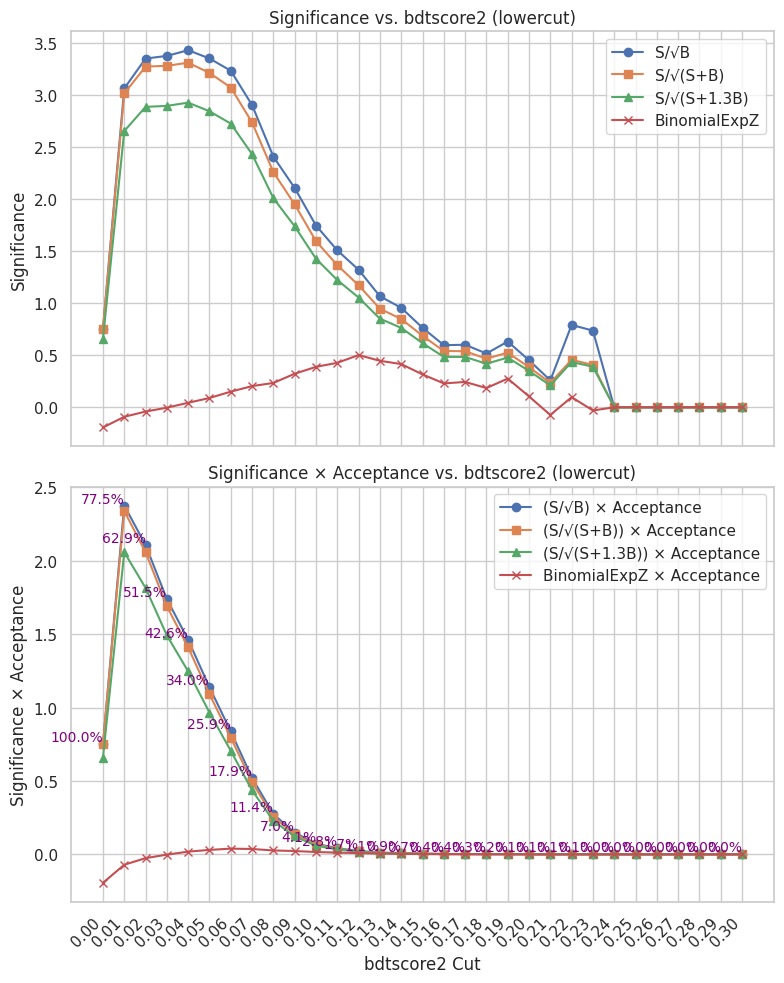

In [14]:
def getCutDict():
    cut_dict = {}
    cut_dict['bdtscore2'] = {
        'lowercut': np.arange(0, 0.3+0.01, 0.01) # BDTScore > cut
    }
    return cut_dict
cut_config = getCutDict()

def calculate_significance(cut_var, cut_type, cut_values, df=df_ml_input):
    sig_simple_list = []
    sig_s_plus_b_list = []
    sig_s_plus_1p3b_list = []
    sig_binomial_list = []

    sigacc_simple_list = []
    sigacc_s_plus_b_list = []
    sigacc_s_plus_1p3b_list = []
    sigacc_binomial_list = []

    acceptance_values = []  # Store acceptance percentages

    df_sig = df[df["label"] == 1]
    df_bkg = df[df["label"] == 0]
    total_sig_weight = df_sig["weights"].sum()

    for cut in cut_values:
        if cut_type == "lowercut":
            sig_cut = df_sig[df_sig[cut_var] >= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] >= cut]
        elif cut_type == "uppercut":
            sig_cut = df_sig[df_sig[cut_var] <= cut]
            bkg_cut = df_bkg[df_bkg[cut_var] <= cut]
        else:
            raise ValueError("Invalid cut type")

        total_signal = sig_cut["weights"].sum()
        total_bkg = bkg_cut['weights'].sum()
        acceptance = total_signal / total_sig_weight if total_sig_weight > 0 else 0
        acceptance_values.append(acceptance * 100)  # percentage

        # Avoid zero division carefully
        if total_bkg > 0:
            sig_simple = total_signal / np.sqrt(total_bkg)
            sig_s_plus_b = total_signal / np.sqrt(total_signal + total_bkg) if (total_signal + total_bkg) > 0 else 0
            sig_s_plus_1p3b = total_signal / np.sqrt(total_signal + 1.3 * total_bkg) if (total_signal + 1.3*total_bkg) > 0 else 0
            sig_binomial = zbi(total_signal, total_bkg, sigma_b_frac=0.3)
        else:
            sig_simple = sig_s_plus_b = sig_s_plus_1p3b = sig_binomial = 0


        # Save significance
        sig_simple_list.append(sig_simple)
        sig_s_plus_b_list.append(sig_s_plus_b)
        sig_s_plus_1p3b_list.append(sig_s_plus_1p3b)
        sig_binomial_list.append(sig_binomial)

        # Save significance × acceptance
        sigacc_simple_list.append(sig_simple * acceptance)
        sigacc_s_plus_b_list.append(sig_s_plus_b * acceptance)
        sigacc_s_plus_1p3b_list.append(sig_s_plus_1p3b * acceptance)
        sigacc_binomial_list.append(sig_binomial * acceptance)

    return (sig_simple_list, sig_s_plus_b_list, sig_s_plus_1p3b_list, sig_binomial_list,
            sigacc_simple_list, sigacc_s_plus_b_list, sigacc_s_plus_1p3b_list, sigacc_binomial_list,
            acceptance_values)

for cut_var, cut_types in cut_config.items():
    for cut_type, cut_values in cut_types.items():
        (sig_simple_list, sig_s_plus_b_list, sig_s_plus_1p3b_list, sig_binomial_list,
         sigacc_simple_list, sigacc_s_plus_b_list, sigacc_s_plus_1p3b_list, sigacc_binomial_list,
         acceptance_values) = calculate_significance(cut_var, cut_type, cut_values)

        # Plot results
        fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

        # Top plot: Significance vs. Cut
        ax_top.plot(cut_values, sig_simple_list, marker='o', label='S/√B')
        ax_top.plot(cut_values, sig_s_plus_b_list, marker='s', label='S/√(S+B)')
        ax_top.plot(cut_values, sig_s_plus_1p3b_list, marker='^', label='S/√(S+1.3B)')
        ax_top.plot(cut_values, sig_binomial_list, marker='x', label='BinomialExpZ')
        ax_top.set_ylabel('Significance')
        ax_top.set_title(f'Significance vs. {cut_var} ({cut_type})')
        ax_top.legend()
        ax_top.grid(True)

        # Bottom plot: Significance * Acceptance vs. Cut
        ax_bot.plot(cut_values, sigacc_simple_list, marker='o', label='(S/√B) × Acceptance')
        ax_bot.plot(cut_values, sigacc_s_plus_b_list, marker='s', label='(S/√(S+B)) × Acceptance')
        ax_bot.plot(cut_values, sigacc_s_plus_1p3b_list, marker='^', label='(S/√(S+1.3B)) × Acceptance')
        ax_bot.plot(cut_values, sigacc_binomial_list, marker='x', label='BinomialExpZ × Acceptance')

        for i, txt in enumerate(acceptance_values):
            ax_bot.text(cut_values[i], sigacc_simple_list[i], f'{txt:.1f}%', 
                        fontsize=10, ha='right', va='bottom', color='purple')
            
        ax_bot.set_xlabel(f'{cut_var} Cut')
        ax_bot.set_ylabel('Significance × Acceptance')
        ax_bot.set_title(f'Significance × Acceptance vs. {cut_var} ({cut_type})')
        
        ax_bot.set_xticks(cut_values)
        ax_bot.set_xticklabels(ax_bot.get_xticks(), rotation=45, ha='right')
        ax_bot.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        # ax_bot.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Show at most 10 x-ticks
        
        ax_bot.legend()
        ax_bot.grid(True)

        plt.tight_layout()
        plt.savefig(f"Correlated_significance_{cut_var}_{cut_type}.png")
        plt.show()
